In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    poutres_path = os.path.join(base_dir, f"maquette{i}", f"poutres{i}.csv")
    if os.path.exists(poutres_path):
        # Cherche la ligne d'en-tête réelle
        with open(poutres_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(poutres_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {poutres_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {poutres_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {poutres_path}")

if dfs:
    poutres_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {poutres_concat.shape[0]} lignes, {poutres_concat.shape[1]} colonnes")
else:
    poutres_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

poutres_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/poutres1.csv (778 lignes, 136 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  822465        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
1  822610        GO        POUTRE          INTERIEUR         PREFA CHANTIER   
2  823043        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
3  823110        GO   BANDE NOYEE            COURANT         COULE EN PLACE   
4  823289        GO   BANDE NOYEE            COURANT         COULE EN PLACE   

       Nom                  AI                 AS Hauteur totale  \
0  30x60ht  -0,200000000000001  0,200000000000001            0,6   
1  25x50ht  -0,150000000000001  0,150000000000001            0,5   
2  30x20ht                -0,1                0,1            0,2   
3  30x20ht                -0,1                0,1            0,2   
4  30x20ht                -0,1                0,1            0,2   

  

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,AI,AS,Hauteur totale,Hauteur,...,Largeur du noyau,Décalage d'alvéole,Nombre d'alvéoles,Hauteur du noyau,D2,D3,D4,D5,Retombé,Hauteur Poutre
0,822465,GO,POUTRE,INTERIEUR,PREFA CHANTIER,30x60ht,"-0,200000000000001","0,200000000000001","0,6","0,400000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822610,GO,POUTRE,INTERIEUR,PREFA CHANTIER,25x50ht,"-0,150000000000001","0,150000000000001","0,5","0,300000000000002",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,823043,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,823110,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,823289,GO,BANDE NOYEE,COURANT,COULE EN PLACE,30x20ht,"-0,1","0,1","0,2","0,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
poutres_concat.shape

(20727, 529)

In [4]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type"
]

# On ne garde que les colonnes présentes dans le DataFrame
poutres_concat = poutres_concat[[col for col in colonnes_a_garder if col in poutres_concat.columns]]

In [5]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

poutres_concat.columns = [clean_col(c) for c in poutres_concat.columns]
print(poutres_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'materiau_structurel', 'famille_et_type']


In [13]:
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in poutres_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans poutres_concat. Colonnes disponibles : {poutres_concat.columns.tolist()}")

# X et y_multi
X = poutres_concat.drop(columns=targets_in_df)
y_multi = poutres_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier et KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction et score
y_pred = pipeline.predict(X_test)
print("Accuracy moyenne multi-label :", (y_pred == y_test.values).mean())

Accuracy moyenne multi-label : 0.9474159488746874


In [7]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 3599 échantillons.


In [8]:
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9474
F1 macro (moyenne par cible): 0.8484


In [9]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.671067
1           012ec_ouvrage  0.793641
3  014ec_mode_constructif  0.929021
0               011ec_lot  1.000000


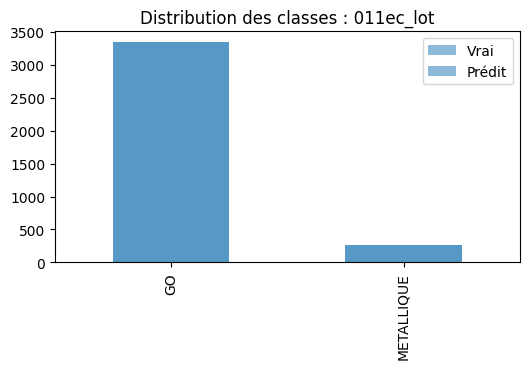

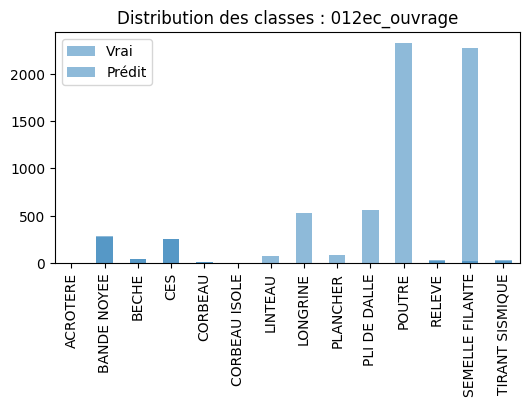

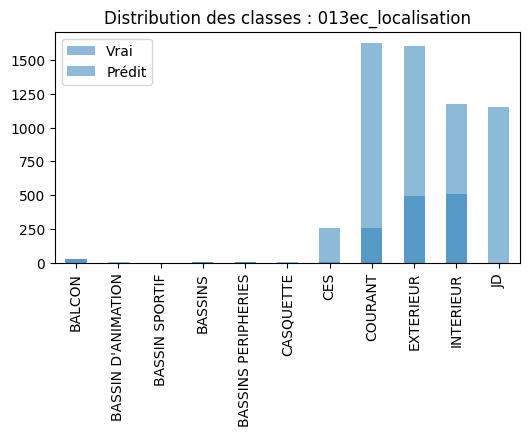

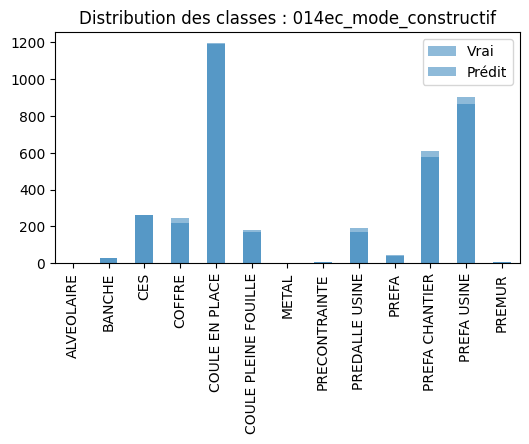

In [10]:
import matplotlib.pyplot as plt

for i, col in enumerate(y_test.columns):
    plt.figure(figsize=(6,3))
    pd.Series(y_test.iloc[:, i]).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Vrai')
    pd.Series(y_pred[:, i]).value_counts().sort_index().plot(kind='bar', alpha=0.5, label='Prédit')
    plt.title(f"Distribution des classes : {col}")
    plt.legend()
    plt.show()